### Setup

In [77]:
import spacy

In [78]:
%%capture
#!python -m spacy download nl_core_news_lg
!python -m spacy download en_core_web_lg

In [79]:
import en_core_web_lg
nlp = en_core_web_lg.load()
doc = nlp("This is a sentence.")
print([(w.text, w.pos_) for w in doc])

[('This', 'PRON'), ('is', 'AUX'), ('a', 'DET'), ('sentence', 'NOUN'), ('.', 'PUNCT')]


In [80]:
doc.vector[:10]

array([-0.0693734 ,  0.26776582, -0.13480794,  0.026144  ,  0.0945714 ,
       -0.1304826 ,  0.0398684 , -0.30131537,  0.0163348 ,  2.28744   ],
      dtype=float32)

In [81]:
import pandas as pd
import numpy as np

In [30]:
pd.read_csv("aut_semdis_input.csv").head()

,id,item,response,response_id,object,respondent_id,temperature
0,1,chair,doorstop,2022040001,book,cmpl-4zrXKRorn55iQY1NXc3Vq3WKCLtyf,0.67
1,2,chair,start a fire,2022040002,book,cmpl-4zrXKRorn55iQY1NXc3Vq3WKCLtyf,0.67
2,3,chair,prop up a table or chair leg,2022040003,book,cmpl-4zrXKRorn55iQY1NXc3Vq3WKCLtyf,0.67
3,4,chair,paperweight,2022040004,book,cmpl-4zrXKRorn55iQY1NXc3Vq3WKCLtyf,0.67
4,5,chair,make art such as by decoupaging it onto a canv...,2022040005,book,cmpl-4zrXKRorn55iQY1NXc3Vq3WKCLtyf,0.67


In [96]:
#dat = pd.read_csv("human_aut_response.csv")
input_file_name = "~/Documents/PythonEnvironments/Claire GPT-3 creativiteit dingen/creAI-gpt3/aut_examples_experiment/semdis/220830_gpt3_aut_examples_experiment_cleaned.csv"
dat = pd.read_csv(input_file_name)
#dat.groupby('user_id')[['participantnr']].value_counts('participantnr')
#dat.groupby('user_id')[['participantnr','AUT-response_id']].value_counts('AUT-response_id')
dat

,Unnamed: 0,research_id,gpt3_id,temperature,respondent_id,response_id,exp_condition,object,response
0,1,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080002,1,book,doorstop
1,2,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080003,1,book,level table
2,3,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080004,1,book,paperweight
3,4,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080005,1,book,help start fire
4,5,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080006,1,book,ripped up d kindling for fire
...,...,...,...,...,...,...,...,...,...
802,803,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080963,5,tin can,Cut the top off of tin c d cdle holder
803,804,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080964,5,tin can,tin c your own DIY mini Piñata
804,805,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080965,5,tin can,cute d festive vase for holiday flowers
805,806,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080966,5,tin can,your own tambourine by decorating empty tin c ...


In [86]:
# rename columns to conform with pilot data
#dat = dat.rename(columns={"AUT-response_id":"response_id", "participantnr":"respondent_id"})
dat = dat.rename(columns={"gpt3_id":"respondent_id"})

if True: # add an 'item' column to conform with the pilot data (not sure what it should be.. does it matter?)
    dat['item'] = 'chair'
    
dat

,Unnamed: 0,research_id,respondent_id,temperature,respondent_id,response_id,exp_condition,object,response,item
0,1,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080002,1,book,doorstop,chair
1,2,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080003,1,book,level table,chair
2,3,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080004,1,book,paperweight,chair
3,4,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080005,1,book,help start fire,chair
4,5,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080006,1,book,ripped up d kindling for fire,chair
...,...,...,...,...,...,...,...,...,...,...
802,803,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080963,5,tin can,Cut the top off of tin c d cdle holder,chair
803,804,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080964,5,tin can,tin c your own DIY mini Piñata,chair
804,805,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080965,5,tin can,cute d festive vase for holiday flowers,chair
805,806,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080966,5,tin can,your own tambourine by decorating empty tin c ...,chair


### Compute semantic distances between response and target object embeddings

We compute both the Euclidean distances and the cosine distances (defined as 1 minus the cosine similarity).

In [87]:
def nlpSRdocvec(doc, keep_sw = False):
    """Compute document vector with stopwords removed"""
    return sum([w.vector for w in doc if keep_sw or not w.is_stop], doc.vector*0)

eucl_item_resp = [np.linalg.norm(nlpSRdocvec(x) - nlpSRdocvec(y)) for x,y in zip(nlp.pipe(dat.item.values), nlp.pipe(dat.response.values))]
eucl_objc_resp = [np.linalg.norm(nlpSRdocvec(x) - nlpSRdocvec(y)) for x,y in zip(nlp.pipe(dat.object.values), nlp.pipe(dat.response.values))]


In [88]:
#cos_sim = lambda x,y: np.dot(x,y)/np.linalg.norm(x)/np.linalg.norm(y) if np.linalg.norm(x)>0 and np.linalg.norm(y) > 0 else 0
def cos_sim(x,y):
    """Compute cosine similarity between vectors 'x' and 'y'. 
    If any of the two vectors has length (norm) 0, 0 is returned."""
    import numpy as np
    xTy = np.dot(x,y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    return  xTy / (norm_x * norm_y) if norm_x > 0 and norm_y > 0 else 0


cos_dist_item_resp = [1-cos_sim(nlpSRdocvec(x),nlpSRdocvec(y)) for x,y in zip(nlp.pipe(dat.item.values), nlp.pipe(dat.response.values))]


Inspect the computed cosine distances: Are they regular? Are there any problems like not-a-numbers?

nr of errors:  0
 elements with error: []


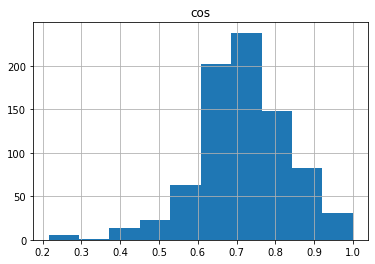

In [89]:
pd.DataFrame({"cos":cos_dist_item_resp}).hist()
print("nr of errors: ", np.sum(np.isnan(cos_dist_item_resp)))
print(" elements with error: %s" % (np.where(np.isnan(cos_dist_item_resp) == True)))

Investigate the above errors (if there are any):

In [90]:

if False: # there were no errors for 'human_aut_response.csv'
    
    print(dat.iloc[971]) # in the pilot case 971 gave an NaN and is investigated here
    nlp(dat.iloc[971].response).vector
    
else:
    
    print('no errors to investigate')

no errors to investigate


Fix any cases by hand if can be:

In [91]:
if False: # there were no errors for 'human_aut_response.csv'
    
    cos_dist_item_resp[971] = 1-cos_sim(nlp("fire lighter").vector, nlp("chair").vector) 
    print('Fixed problematic cases by hand. Check code!')
    
else:
    
    print('Nothing to fix.')

Nothing to fix.


Compute the cosine distances&mdash;i.e., 1-cosine similarity (!)&mdash;between the 'object' and 'response' embeddings:

In [92]:
cos_dist_objc_resp = [1-cos_sim(nlpSRdocvec(x),nlpSRdocvec(y)) for x,y in zip(nlp.pipe(dat.object.values), nlp.pipe(dat.response.values))]


Correct any problematic cases identified earlier by hand, if necessary:

In [93]:
if False: # there were no errors for 'human_aut_response.csv'
    
    cos_dist_objc_resp[971] = 1-cos_sim(nlp("fire lighter").vector, nlp("book").vector) 
    print('Corrected problematic cases by hand. Check code!')

else:
    
    print('Nothing to correct by hand.')

Nothing to correct by hand.


### Write semantic distances to file

Augment data frame with the distances:

In [97]:
dat['eucl_item_resp'] = eucl_item_resp
dat['eucl_objc_resp'] = eucl_objc_resp
dat['cos_dist_item_resp'] = cos_dist_item_resp
dat['cos_dist_objc_resp'] = cos_dist_objc_resp

In [98]:
dat

,Unnamed: 0,research_id,gpt3_id,temperature,respondent_id,response_id,exp_condition,object,response,eucl_item_resp,eucl_objc_resp,cos_dist_item_resp,cos_dist_objc_resp
0,1,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080002,1,book,doorstop,8.658492,8.365611,0.854830,0.847086
1,2,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080003,1,book,level table,9.062929,10.400023,0.513296,0.720937
2,3,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080004,1,book,paperweight,8.695191,8.987339,0.830964,0.939968
3,4,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080005,1,book,help start fire,13.495851,13.020587,0.723251,0.664647
4,5,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080006,1,book,ripped up d kindling for fire,15.212108,15.420358,0.747015,0.789326
...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,803,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080963,5,tin can,Cut the top off of tin c d cdle holder,19.640327,17.016212,0.696665,0.350269
803,804,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080964,5,tin can,tin c your own DIY mini Piñata,18.749374,15.527498,0.717618,0.298052
804,805,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080965,5,tin can,cute d festive vase for holiday flowers,25.776705,24.742960,0.714691,0.569614
805,806,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080966,5,tin can,your own tambourine by decorating empty tin c ...,29.883509,27.314657,0.686507,0.335737


In [100]:
output_file_name = input_file_name.replace(".csv", "_w_dists.csv")
dat.to_csv(output_file_name,index=False)

### Compute semantic distances between subsequent responses within respondents

In [56]:
dat = pd.read_csv("human_aut_response_w_dists.csv")
dat #= dat.drop(['Unnamed: 0'], axis=1)

,user_id,respondent_id,response_id,object,response,item,eucl_item_resp,eucl_objc_resp,cos_dist_item_resp,cos_dist_objc_resp
0,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47511,fork,As a comb,chair,8.546967,8.013143,0.824967,0.732309
1,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47512,fork,To decorate pottery,chair,11.685653,12.155675,0.716931,0.790782
2,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47513,fork,Body scratcher,chair,9.233773,10.531011,0.595530,0.795708
3,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47514,fork,Shoehorn,chair,8.791459,7.873101,0.989949,0.799006
4,3314,prolific_participantid_5422cca4fdf99b328c91b21b,47515,fork,Sandcastle flag,chair,11.836369,11.581881,0.859517,0.823172
...,...,...,...,...,...,...,...,...,...,...
4691,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45030,tin can,String telephone,chair,11.349264,11.574689,0.738724,0.781443
4692,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45031,tin can,in artwork,chair,8.841945,8.989683,0.820508,0.866333
4693,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45032,tin can,desk tidy/holding stationary,chair,15.378700,17.325891,0.452562,0.711372
4694,3122,prolific_participantid_63089b4ddcb40dc001bd6ea5,45033,tin can,collecting money/change,chair,14.823507,14.819868,0.759585,0.763787


In [101]:
from scipy.spatial.distance import cosine
cos_sim = lambda x,y: np.dot(x,y)/np.linalg.norm(x)/np.linalg.norm(y) if np.linalg.norm(x)>0 and np.linalg.norm(y) > 0 else 0
cos_sim = lambda x,y: 1-cosine(x,y) if np.linalg.norm(x)>0 and np.linalg.norm(y) > 0 else 0

def cos_sim(x,y):
    """An attempt to obtain a safer version of the cosine similarity that doesn't produce values larger than 1. It fails misserably"""
    normx = np.linalg.norm(x)
    normy = np.linalg.norm(y)
    if not normx > 0 or not normy > 0:
        return 0
    normxy = np.linalg.norm(x-y)
    return 0.5*(normx/normy + normy/normx - normxy**2/(normx*normy))

# let's just go back to the old definition of the function
cos_sim = lambda x,y: cosine(x,y) if np.linalg.norm(x)>0 and np.linalg.norm(y) > 0 else 0

In [102]:
def nlpSR(string, keep_sw = False):
    """Compute document vector with stopwords removed"""
    doc = nlp(string)
    return sum([w.vector for w in doc if keep_sw or not w.is_stop], doc.vector*0)

def conseq_semdis(df):
    """Compute semantic distances of consequtive responses in df"""
    resp = df.response.values
    if len(resp) > 1:
        csq_semdis = [2]+[1-cos_sim(nlpSR(resp[i+1]),nlpSR(resp[i])) for i in range(len(df)-1)]
    else:
        csq_semdis = [2]
    df['semdis_prev'] = csq_semdis
    return df

dat2 = dat.sort_values(['respondent_id','response_id','object']).groupby('respondent_id').apply(conseq_semdis)
dat2

,Unnamed: 0,research_id,gpt3_id,temperature,respondent_id,response_id,exp_condition,object,response,eucl_item_resp,eucl_objc_resp,cos_dist_item_resp,cos_dist_objc_resp,semdis_prev
0,1,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080002,1,book,doorstop,8.658492,8.365611,0.854830,0.847086,2.000000
1,2,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080003,1,book,level table,9.062929,10.400023,0.513296,0.720937,-0.019999
2,3,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080004,1,book,paperweight,8.695191,8.987339,0.830964,0.939968,0.096630
3,4,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080005,1,book,help start fire,13.495851,13.020587,0.723251,0.664647,0.001037
4,5,GPT3202208,cmpl-5kwPhu78O2gzaQVpMQ0C6t1LLcznX,0.6,202208001,2022080006,1,book,ripped up d kindling for fire,15.212108,15.420358,0.747015,0.789326,0.611636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,803,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080963,5,tin can,Cut the top off of tin c d cdle holder,19.640327,17.016212,0.696665,0.350269,0.261075
803,804,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080964,5,tin can,tin c your own DIY mini Piñata,18.749374,15.527498,0.717618,0.298052,0.669487
804,805,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080965,5,tin can,cute d festive vase for holiday flowers,25.776705,24.742960,0.714691,0.569614,0.565539
805,806,GPT3202208,cmpl-5kwYTj2kBGA94qJZUMvY5TXYLPnST,0.8,202208150,2022080966,5,tin can,your own tambourine by decorating empty tin c ...,29.883509,27.314657,0.686507,0.335737,0.612728


In [103]:
np.where(dat2.semdis_prev.values > 1)
#1-cosine(nlpSR(tmp.response.values[3]),nlpSR(tmp.object.values[3]))
#tmp[tmp.respondent_id == 'BP20160025']
#1-cosine(nlpSR(tmp.response.values[3]),nlpSR(tmp.object.values[3]))
#tmp.groupby('object').apply(conseq_semdis)
#tmp.iloc[4:6].groupby('object').apply(conseq_semdis)
#1-cos_sim(nlpSR(tmp.iloc[4:6].response.values[0]), nlpSR(tmp.iloc[4:6].response.values[1]))

(array([  0,   6,  11,  15,  20,  25,  32,  35,  40,  48,  52,  57,  62,
         67,  72,  80,  88,  95, 100, 105, 110, 116, 122, 127, 130, 136,
        142, 147, 152, 157, 164, 170, 174, 181, 185, 189, 195, 200, 205,
        211, 215, 220, 225, 232, 240, 245, 249, 252, 255, 258, 264, 270,
        274, 280, 285, 290, 296, 304, 309, 313, 321, 326, 331, 337, 345,
        351, 356, 359, 364, 370, 374, 381, 387, 392, 395, 400, 405, 411,
        417, 423, 427, 431, 436, 442, 446, 451, 459, 464, 468, 471, 476,
        483, 491, 496, 500, 505, 511, 519, 523, 528, 532, 537, 541, 548,
        552, 557, 564, 569, 572, 577, 585, 590, 596, 600, 605, 610, 616,
        622, 628, 633, 639, 646, 653, 658, 663, 668, 675, 678, 685, 691,
        697, 704, 709, 712, 717, 722, 727, 733, 736, 744, 751, 757, 761,
        765, 770, 776, 782, 787, 796, 801]),)

<AxesSubplot:>

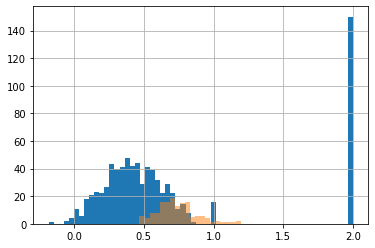

In [104]:
dat2.semdis_prev.hist(bins=60)
dat2.groupby(['respondent_id','object']).mean().semdis_prev.hist(alpha=0.5,bins=20)

## Push to github

In [61]:
!ls

aut_semdis_input.csv                  human_aut_response_w_dists.csv
aut_semdis_input_w_dists.csv          semdis_computations_spacy.ipynb
human_aut_response.csv                semdis_human+gpt3_differences_R.ipynb


In [107]:
#dat2.to_csv("aut_semdis_input_w_dists.csv")
#!mv *.csv ./aut_pilot_ICCC22/semdis/.

In [108]:
%cd /Users/raoul/Documents/PythonEnvironments/Claire GPT-3 creativiteit dingen/creAI-gpt3/
%ls -la

/Users/raoul/Documents/PythonEnvironments/Claire GPT-3 creativiteit dingen/creAI-gpt3
total 0
drwxr-xr-x@  7 raoul  staff  224 Aug 30 20:38 ./
drwxr-xr-x@  6 raoul  staff  192 Aug 30 20:38 ../
drwxr-xr-x@ 15 raoul  staff  480 Aug 30 20:38 .git/
drwxr-xr-x@  3 raoul  staff   96 Aug 30 11:06 .ipynb_checkpoints/
-rw-r--r--   1 raoul  staff    0 May 26 12:10 README.md
drwxr-xr-x@  5 raoul  staff  160 Aug 30 20:38 aut_examples_experiment/
drwxr-xr-x@ 13 raoul  staff  416 Aug 30 11:25 aut_pilot_ICCC22/


In [109]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   aut_examples_experiment/semdis/semdis_computations_spacy.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	aut_examples_experiment/semdis/220830_gpt3_aut_examples_experiment_cleaned.csv
	aut_examples_experiment/semdis/220830_gpt3_aut_examples_experiment_cleaned_w_dists.csv
	aut_pilot_ICCC22/.ipynb_checkpoints/
	aut_pilot_ICCC22/semdis/.ipynb_checkpoints/

no changes added to commit (use "git add" and/or "git commit -a")


In [110]:
#!git rm ./aut_pilot_ICCC22/aut_semdis_input_w_dists.csv
#!git rm ./aut_pilot_ICCC22/semdis_computations_spacy.ipynb
#!git rm ./aut_pilot_ICCC22/semdis_human+gpt3_differences_R.ipynb
#!mv *.csv ./aut_pilot_ICCC22/semdis/.
#!git add ./aut_pilot_ICCC22/semdis/*
!git add ./aut_examples_experiment/*
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   aut_examples_experiment/semdis/220830_gpt3_aut_examples_experiment_cleaned.csv
	new file:   aut_examples_experiment/semdis/220830_gpt3_aut_examples_experiment_cleaned_w_dists.csv
	modified:   aut_examples_experiment/semdis/semdis_computations_spacy.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	aut_pilot_ICCC22/.ipynb_checkpoints/
	aut_pilot_ICCC22/semdis/.ipynb_checkpoints/



In [179]:
#!git commit -a -m 'recomputed semantic distances with stop words removed'

[master c5e6cdd] removed old files
 Committer: Raoul Grasman <raoul@Raouls-MacBook-Air-2021.local>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 6 files changed, 2444 insertions(+), 5010 deletions(-)
 delete mode 100644 aut_pilot_ICCC22/aut_semdis_input_w_dists.csv
 rewrite aut_pilot_ICCC22/semdis/aut_semdis_input_w_dists.csv (96%)
 delete mode 100644 aut_pilot_ICCC22/semdis_computations_spacy.ipynb
 delete mode 100644 aut_pilot_ICCC22/semdis_human+gpt3_differences_R.ipynb


In [181]:
#!git config --global user.email "rgrasman@uva.nl"

In [183]:
#!git commit --amend --reset-author -m 'Removed old files'

[master 0172eaa] Removed old files
 6 files changed, 2444 insertions(+), 5010 deletions(-)
 delete mode 100644 aut_pilot_ICCC22/aut_semdis_input_w_dists.csv
 rewrite aut_pilot_ICCC22/semdis/aut_semdis_input_w_dists.csv (96%)
 delete mode 100644 aut_pilot_ICCC22/semdis_computations_spacy.ipynb
 delete mode 100644 aut_pilot_ICCC22/semdis_human+gpt3_differences_R.ipynb


In [73]:
!git commit -a -m 'computed semantic distances for human_aut_response.csv'

[master a197fed] computed semantic distances for human_aut_response.csv
 9 files changed, 18707 insertions(+), 13 deletions(-)
 create mode 100644 aut_examples_experiment/semdis/.ipynb_checkpoints/semdis_computations_spacy-checkpoint.ipynb
 create mode 100644 aut_examples_experiment/semdis/.ipynb_checkpoints/semdis_human+gpt3_differences_R-checkpoint.ipynb
 create mode 100644 aut_examples_experiment/semdis/aut_semdis_input.csv
 create mode 100644 aut_examples_experiment/semdis/aut_semdis_input_w_dists.csv
 create mode 100644 aut_examples_experiment/semdis/human_aut_response.csv
 create mode 100644 aut_examples_experiment/semdis/human_aut_response_w_dists.csv
 create mode 100644 aut_examples_experiment/semdis/semdis_computations_spacy.ipynb
 create mode 100644 aut_examples_experiment/semdis/semdis_human+gpt3_differences_R.ipynb


In [76]:
!git push

Enumerating objects: 16, done.
Counting objects: 100% (16/16), done.
Delta compression using up to 8 threads
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 1.57 MiB | 2.81 MiB/s, done.
Total 12 (delta 4), reused 2 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 3 local objects.
To https://github.com/cstevenson-uva/creAI-gpt3.git
   d32ffe4..a197fed  master -> master
